## ML Models


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree

%run ../model_preparation/import_model_data.ipynb
%store -r model_df

model_df['Year'] = model_df['time'].dt.year
model_df['Month'] = model_df['time'].dt.month
model_df['Day'] = model_df['time'].dt.day
model_df['Hour'] = model_df['time'].dt.hour

model_df.drop('time', axis=1, inplace=True)

# Umwandlung kategorialer Variablen in Dummy-Variablen
model_df = pd.get_dummies(model_df, columns=['Weekday', 'weather_description'])

model_df['siteIDIsOne'] = model_df['siteID'] == '1'
model_df.drop('siteID', axis=1, inplace=True)

# Zielvariable und Merkmale trennen
X = model_df.drop('occupied_count', axis=1)  # Merkmale
y = model_df['occupied_count']               # Zielvariable

# Aufteilen in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

C:\Users\Jasper\AppData\Local\Temp\ipykernel_20716\1315465959.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Stored 'model_df' (DataFrame)


### Linear regression


In [12]:
pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('lin_reg', LinearRegression())
])

# Einstellen der Parameter für die Kreuzvalidierung
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Durchführen der Kreuzvalidierung
scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')

print(f"Durchschnittlicher Mean Squared Error während Kreuzvalidierung: {np.mean(-scores)}")


# Trainieren des Modells mit allen Trainingsdaten
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error: {test_mse}")

Durchschnittlicher Mean Squared Error während Kreuzvalidierung: 129.06939425013383
Test Mean Squared Error: 126.79444817490875


### Polynomial regression


In [13]:

# Definieren der Pipeline
# Nachdem ich viele verschiedene Parameter versucht habe, habe ich mit diesen das beste Ergebnis erreicht
# Eine Kreuzvalidierung mittels beispielsweise GridSearchCV dauert zu lange
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=4)),
    ('scaling', StandardScaler()),
    ('ridge', Ridge(alpha=0.01))
])

# Training des Modells auf den Trainingsdaten
pipeline.fit(X_train, y_train)

# Vorhersage auf den Testdaten
y_pred = pipeline.predict(X_test)

# Berechnung des Mean Squared Error (MSE) auf den Testdaten
test_mse = mean_squared_error(y_test, y_pred)

print("Test MSE:", test_mse)

Test MSE: 75.25571557077296


### Decision Tree


### Plot different Hyperparameters to determine wich one to choose


In [18]:
%run ../model_preparation/import_model_data.ipynb
%store -r model_df

# Aufteilen der 'time'-Spalte in Jahr, Monat, Tag und Stunde
model_df['Year'] = model_df['time'].dt.year
model_df['Month'] = model_df['time'].dt.month
model_df['Day'] = model_df['time'].dt.day
model_df['Hour'] = model_df['time'].dt.hour
model_df.drop('time', axis=1, inplace=True)

# Ich halte mögliche Vergleiche wie Weekday >= 5 sinnvoll, um Wochentag und Wochenende unterscheiden zu können
weekday_map = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
model_df['Weekday'] = model_df['Weekday'].map(weekday_map)

# Umwandlung kategorialer Variablen in Dummy-Variablen
model_df = pd.get_dummies(model_df, columns=['weather_description'])

# Zielvariable und Merkmale trennen
X = model_df.drop('occupied_count', axis=1)
y = model_df['occupied_count']

# Aufteilen in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Parameter für GridSearchCV
param_grid = {
    'max_depth': np.arange(5, 26, 5).tolist(), 
    'min_samples_leaf': [10, 20, 50, 100],      
    'ccp_alpha': np.linspace(0.0, 0.1, 10).tolist()
}

# GridSearchCV auf den Trainingsdaten
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

# GridSearchCV auf den Trainingsdaten
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

# GridSearchCV auf den Trainingsdaten
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

# Ergebnisse extrahieren
cv_results = pd.DataFrame(grid_search.cv_results_)

# Funktion zur Erstellung eines Plots für einen gegebenen Hyperparameter
def plot_param_variation(cv_results, param_name):
    # Sicherstellen, dass die Parameterwerte numerisch sind
    param_values = cv_results[f'param_{param_name}'].unique()
    param_values = np.sort(np.array(param_values, dtype=float))

    train_scores = []
    test_scores = []
    
    # Durchschnittliche Scores für jeden Parameterwert berechnen
    for value in param_values:
        train_scores.append(cv_results[cv_results[f'param_{param_name}'] == value]['mean_train_score'].mean())
        test_scores.append(cv_results[cv_results[f'param_{param_name}'] == value]['mean_test_score'].mean())
    
    plt.figure(figsize=(10, 6))
    plt.title(f"Mean Squared Error for different {param_name}")
    plt.xlabel(f"effective {param_name}")
    plt.ylabel("Mean Squared Error")
    plt.plot(param_values, -np.array(train_scores), label="train", marker='o')  # Negatives Vorzeichen umkehren
    plt.plot(param_values, -np.array(test_scores), label="test", marker='o')   # Negatives Vorzeichen umkehren
    plt.legend()
    plt.show()

# Plots für ccp_alpha, max_depth und min_samples_leaf
plot_param_variation(cv_results, 'ccp_alpha')
plot_param_variation(cv_results, 'max_depth')
plot_param_variation(cv_results, 'min_samples_leaf')

Stored 'model_df' (DataFrame)


### Choosing Hyperparameter based on plots

Based on the plots we choose:
max_depth = 10
min_samples_leaf = 10
ccp_alpha = 0.05


Test MSE: 13.42663219100832


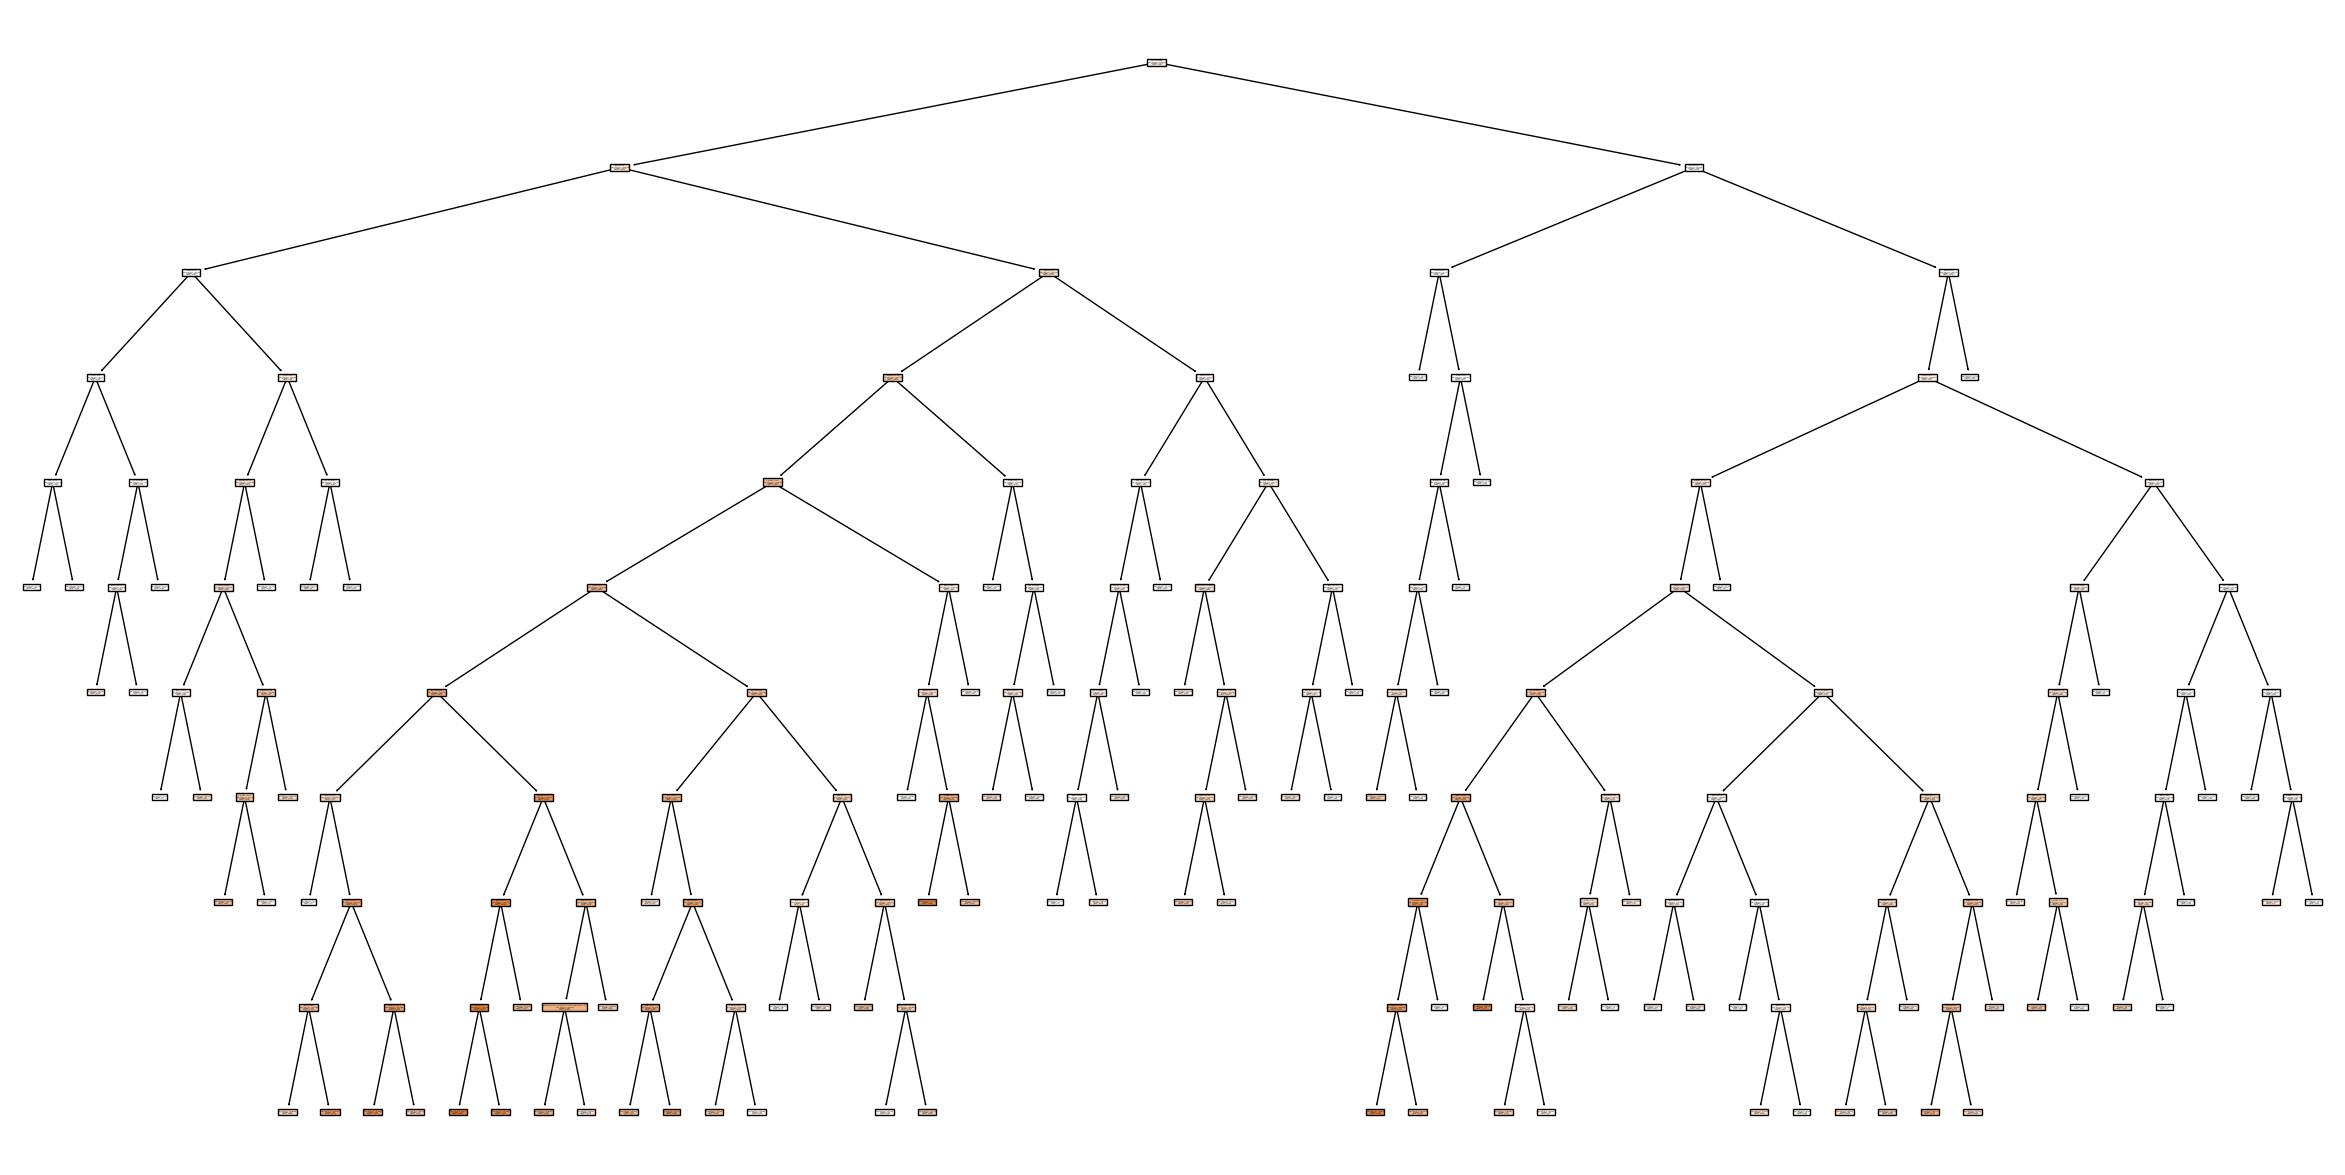

In [17]:
tree_regressor = DecisionTreeRegressor(max_depth=10, min_samples_leaf=10, ccp_alpha=0.05, random_state=42)

# Trainieren des Modells mit den Trainingsdaten
tree_regressor.fit(X_train, y_train)

# Vorhersagen auf den Testdaten machen
y_pred = tree_regressor.predict(X_test)

# Bewertung auf den Testdaten
test_mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", test_mse)

# Visualisierung des Baumes
plt.figure(figsize=(30, 15))
plot_tree(tree_regressor, feature_names=X.columns, filled=True)
plt.savefig('../../decision_tree.svg', format='svg')
plt.show()
plt.close()